# Developing Well Calibrated Illness Severity Scores
## Model Analysis
### C.V. Cosgriff, MIT Critical Data

With our models developed, we will examine their discrimination and calibration. Discrimination will be examined via area under the reciever-operator characteristic curve (AUC). Calibration will be examined via reliability curves and observed-to-predicted mortality ratios. Metrics will have conservative 95% confidence intervals constructed via bootstrapping.

__Notebook Outline:__
* Envrionment preparation
* Load held out test set
* RS Models
* HR Models
* Combined graphics
* Feature Analysis
    
## 0 - Environement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance

import pickle

# "Tableau 20" colors as RGB for plotting
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - Models, Data, and Helper Functions

We first load up the fully trained models.

In [2]:
ridge_classifier = pickle.load(open('./models/ridge_full-cohort', 'rb'))
ridge_classifier_HR = pickle.load(open('./models/ridge_HR-cohort', 'rb'))
xgb_classifier = pickle.load(open('./models/xgb_full-cohort', 'rb'))
xgb_classifier_HR = pickle.load(open('./models/xgb_HR-cohort', 'rb'))

We then load up the testing data and generate high-risk testing cohort.

In [3]:
test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

test_X_HR = test_X[(test_apache >= 0.10), :]
test_y_HR = test_y[test_apache >= 0.10]

Finally, we introduce  helper functions for calculating the CI for the metrics via bootstrapping and for generating plots.

In [4]:
def auc_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1 - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_auc = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        auc = roc_auc_score(y_true[indices], f_hat[indices])
        bootstrapped_auc.append(auc)

    sorted_scores = np.array(bootstrapped_auc)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_opr = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        opr = y_true[indices].mean() / f_hat[indices].mean()
        bootstrapped_opr.append(opr)

    sorted_scores = np.array(bootstrapped_opr)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def gen_auc_plot(models, names, colors, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        roc = roc_curve(y, f_hat[:, 1])
        auc = roc_auc_score(y, f_hat[:, 1])
        plt.plot(roc[0], roc[1], color=colors[i], 
         label='{0}\n(AUC = {1:.3f} [{2:.3f}, {3:.3f}])'.format(names[i], auc, *auc_ci(f_hat[:, 1], y)))
    
    plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if save_name != None:
        plt.savefig('./figures/' + save_name + '.svg', bbox_inches='tight')
    plt.show()
    
def gen_calib_plot(models, names, colors, title, X, y, save_name=None):
    plt.figure(figsize=(10, 10))
    for i, model in enumerate(models):
        f_hat = model.predict_proba(X)
        fraction_of_positives, mean_predicted_value = calibration_curve(y, f_hat[:, 1], n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, color=colors[i], 
         label=names[i])
    
    plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
    plt.ylabel("Fraction of positives")
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("Mean predicted value")
    plt.grid()
    if save_name != None:
        plt.savefig('./figures/' + save_name + '.svg', bbox_inches='tight')
    plt.show()
    
def op_ratio(model, X, y):
    f_hat = model.predict_proba(X)
    observed = y.mean()
    predicted = f_hat[:, 1].mean()
    return (observed / predicted, *op_ratio_ci(f_hat[:, 1], y))

## 2 - Models Fit in the RS Cohort

Here we will examine how the models trained in the RS cohort perform in a cohort composed of only high-risk patients.

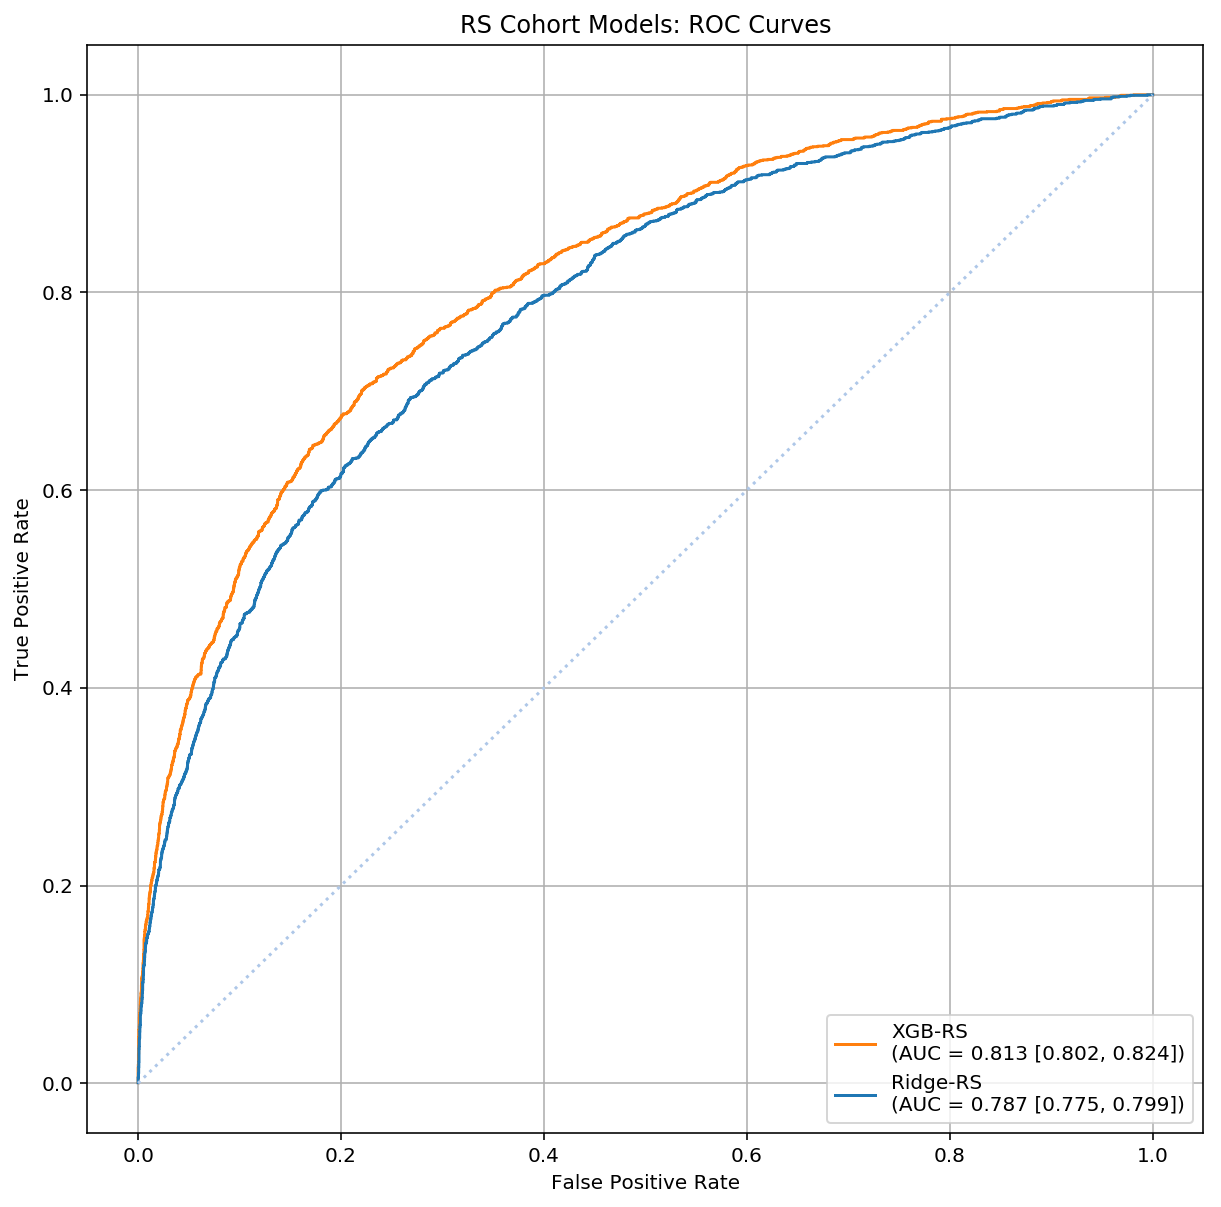

In [5]:
gen_auc_plot(models=[xgb_classifier, ridge_classifier], names=['XGB-RS', 'Ridge-RS'], 
             colors=[tableau20[2], tableau20[0]], title='RS Cohort Models: ROC Curves', X=test_X_HR, 
             y=test_y_HR, save_name='roc_RS')

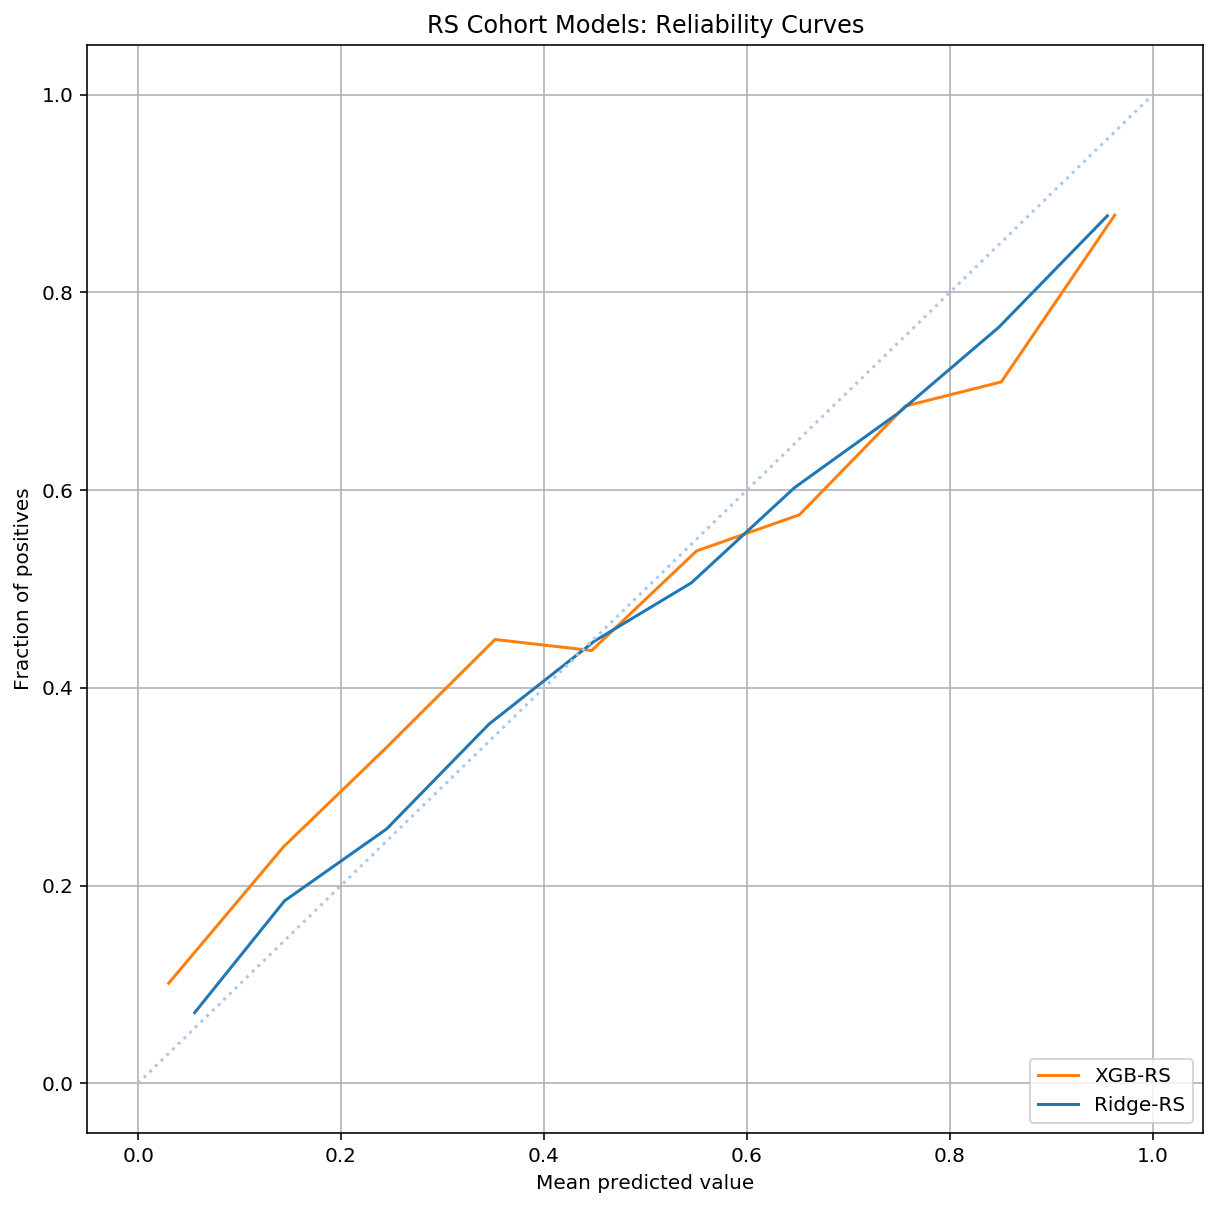

In [6]:
gen_calib_plot(models=[xgb_classifier, ridge_classifier], names=['XGB-RS', 'Ridge-RS'], 
             colors=[tableau20[2], tableau20[0]], title='RS Cohort Models: Reliability Curves', 
               X=test_X_HR, y=test_y_HR, save_name='rel_RS')

In [7]:
print('Ridge-RS OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(ridge_classifier, test_X_HR, test_y_HR)))
print('XGB-RS OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(xgb_classifier, test_X_HR, test_y_HR)))

Ridge-RS OPR: 1.040 [1.005, 1.075]
XGB-RS OPR: 1.265 [1.221, 1.310]


## 3 - Models Fit in the HR Cohort

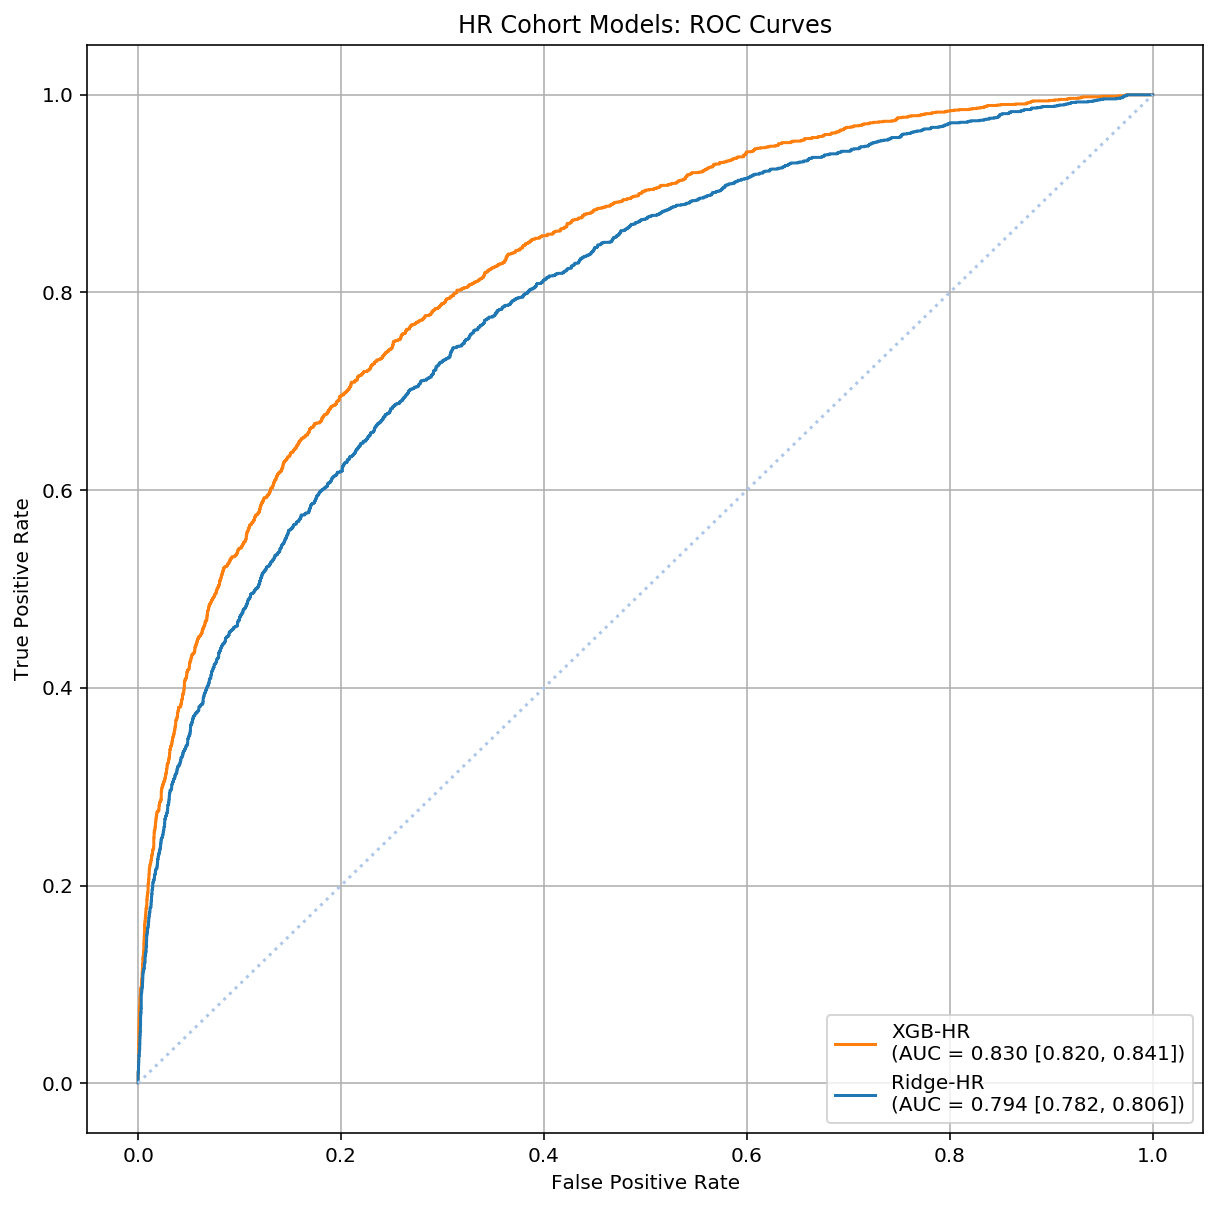

In [8]:
gen_auc_plot(models=[xgb_classifier_HR, ridge_classifier_HR], names=['XGB-HR', 'Ridge-HR'], 
             colors=[tableau20[2], tableau20[0]], title='HR Cohort Models: ROC Curves', X=test_X_HR, 
             y=test_y_HR, save_name='roc_HR')

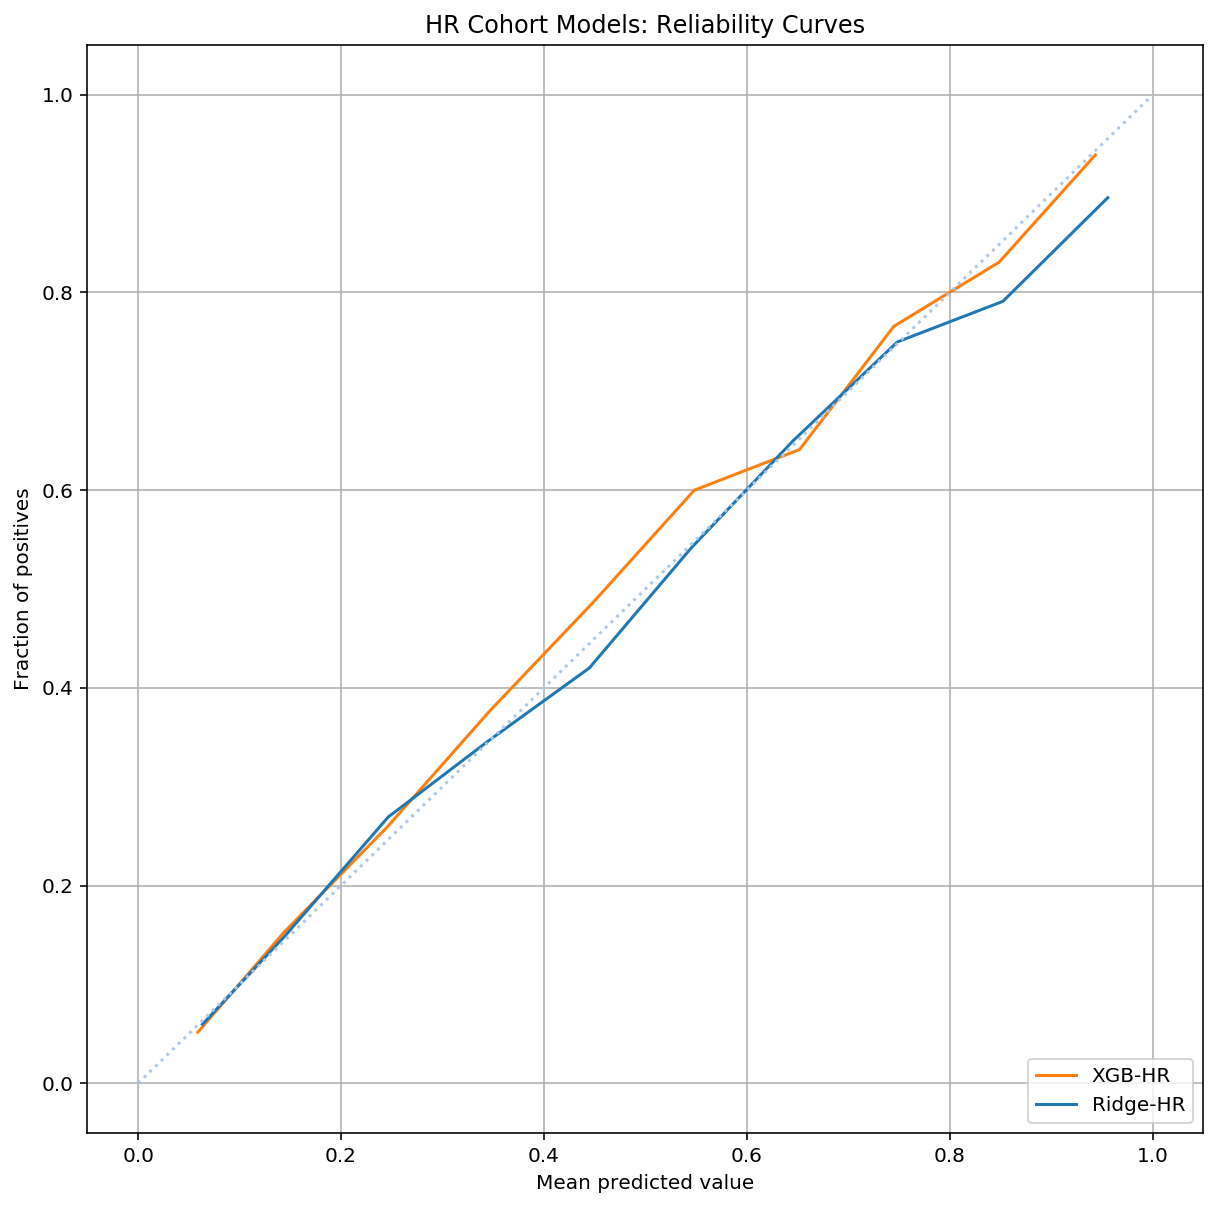

In [9]:
gen_calib_plot(models=[xgb_classifier_HR, ridge_classifier_HR], names=['XGB-HR', 'Ridge-HR'], 
             colors=[tableau20[2], tableau20[0]], title='HR Cohort Models: Reliability Curves', 
               X=test_X_HR, y=test_y_HR, save_name='rel_HR')

In [10]:
print('Ridge-HR OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(ridge_classifier_HR, test_X_HR, test_y_HR)))
print('XGB-HR OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(*op_ratio(xgb_classifier_HR, test_X_HR, test_y_HR)))

Ridge-HR OPR: 1.001 [0.967, 1.034]
XGB-HR OPR: 1.030 [0.998, 1.063]


## 4 - Combined Graphs

We'll produce combined versions of these graphs for publication.

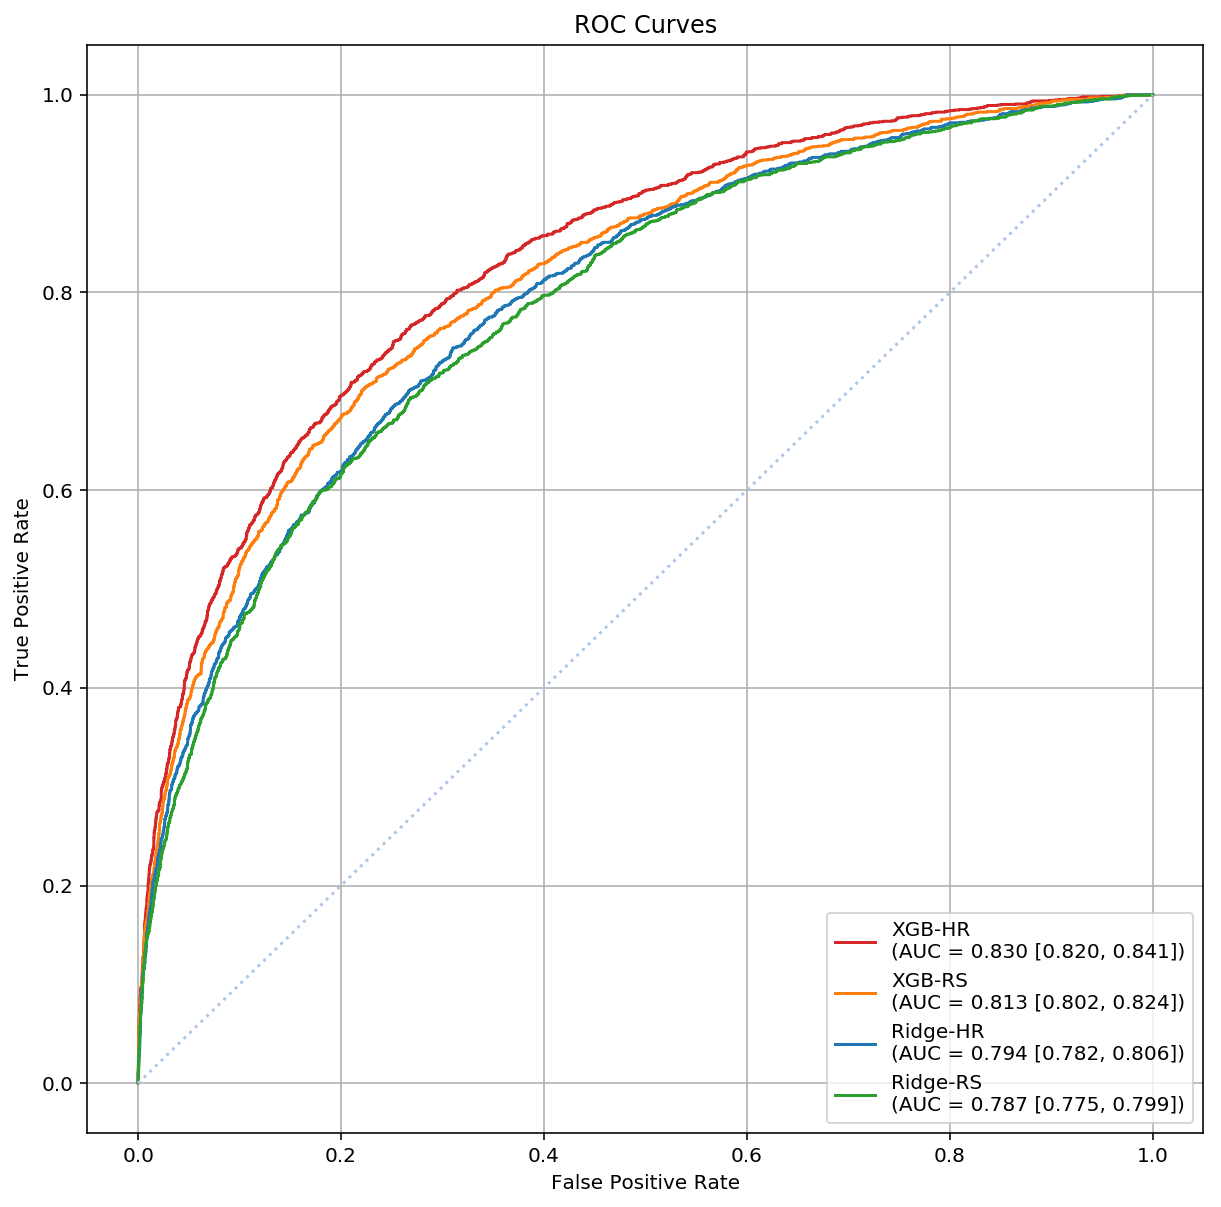

In [11]:
gen_auc_plot(models=[xgb_classifier_HR, xgb_classifier, ridge_classifier_HR, ridge_classifier], 
             names=['XGB-HR', 'XGB-RS', 'Ridge-HR', 'Ridge-RS'], title='ROC Curves',
             colors=[tableau20[6], tableau20[2], tableau20[0], tableau20[4]], X=test_X_HR, 
             y=test_y_HR, save_name='roc_all')

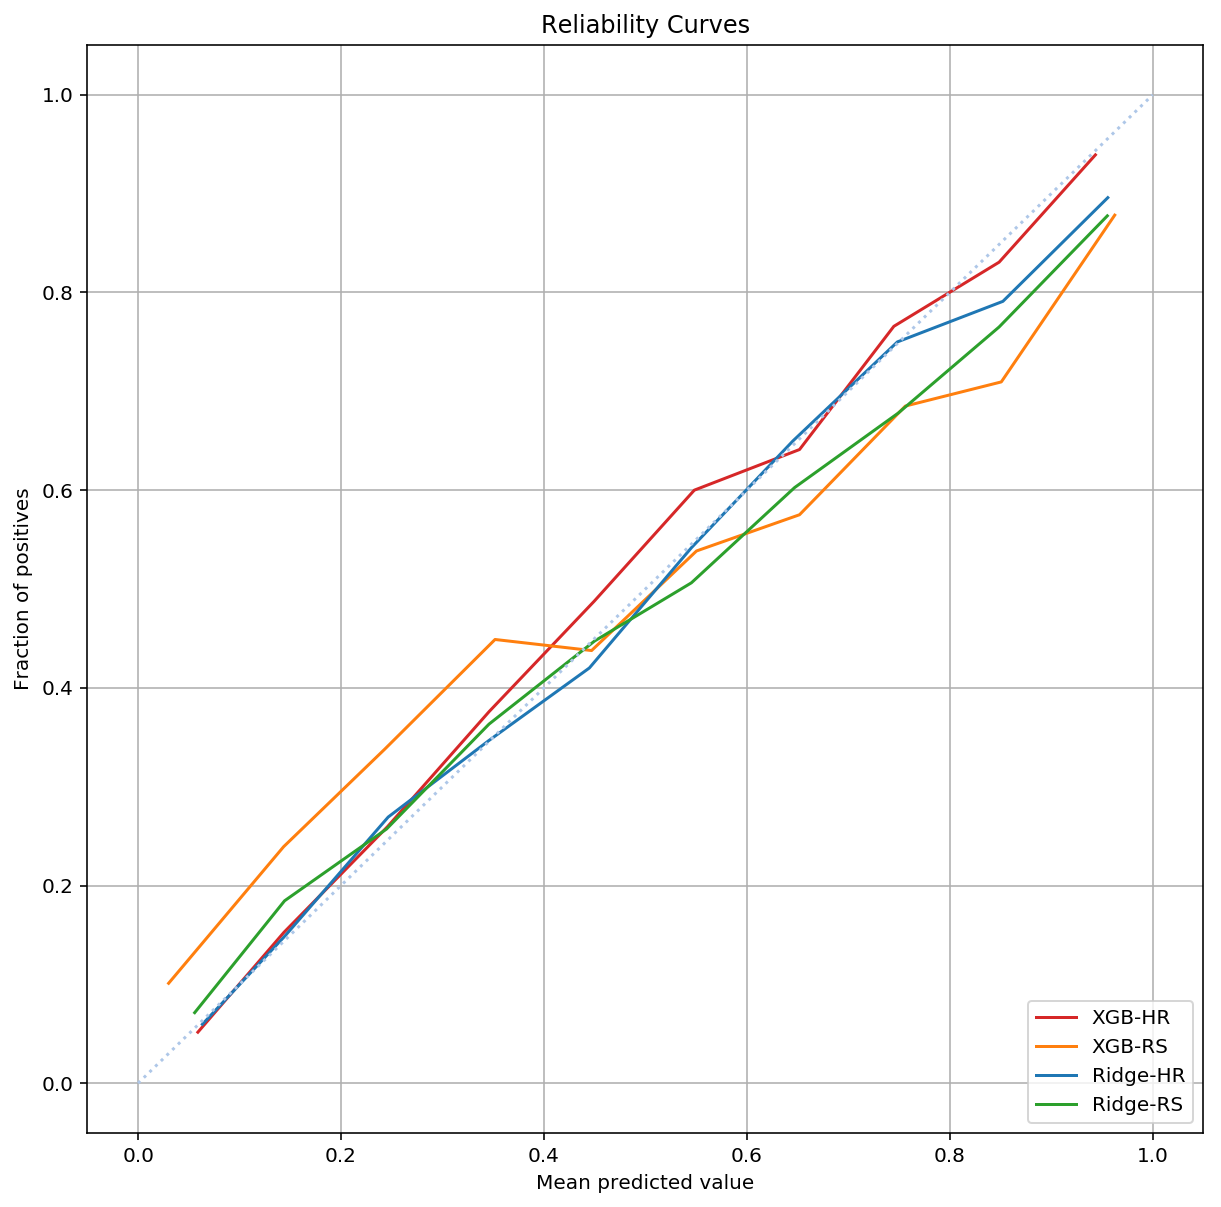

In [12]:
gen_calib_plot(models=[xgb_classifier_HR, xgb_classifier, ridge_classifier_HR, ridge_classifier], 
             names=['XGB-HR', 'XGB-RS', 'Ridge-HR', 'Ridge-RS'], title='Reliability Curves',
             colors=[tableau20[6], tableau20[2], tableau20[0], tableau20[4]], X=test_X_HR, 
               y=test_y_HR, save_name='rel_all')

## 5 - Feature Analysis

The features of the ridge models may be examined via the log(OR) associated with each feature. Similary, although not directly comparable, the information gain of the features in the gradient boosted models may provide insight. 

We first extract the feature names.

In [13]:
feature_names = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').columns

For the ridge models, we'll manually extract the coefficient array, which has its order preserved, and assign the feature names so that we can easily read the sorted list. We examine the RS cohort model first.

,log_odds
albumin_min,-0.369082
age,0.321404
apache_ventday1,0.317588
hr_mean,0.307437
adx_CVA,0.287425
charlson,0.284680
adx_ValveDz,-0.267173
adx_CABG,-0.256525
spo2_mean,-0.250131
map_aperiodic_mean,-0.248259


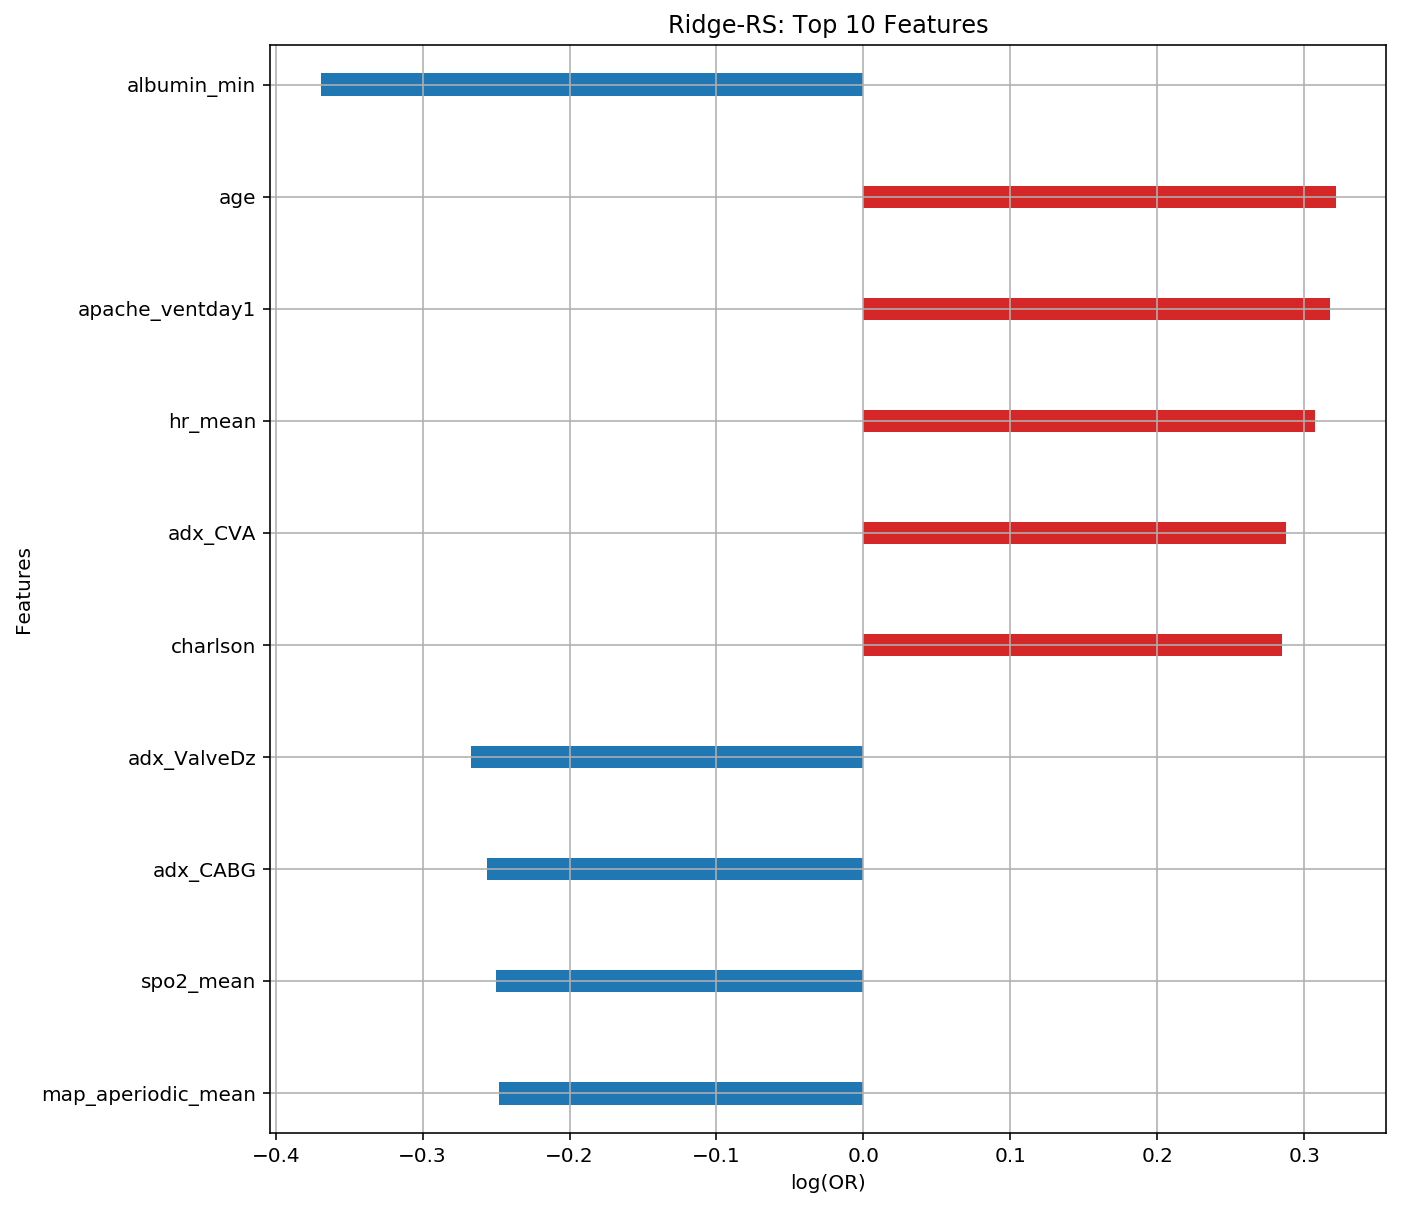

In [14]:
ridge_coef = {k:v for k, v in zip(feature_names, ridge_classifier.named_steps['ridge'].coef_.ravel())}
ridge_coef = pd.DataFrame.from_dict(ridge_coef, orient='index', columns=['log_odds'])
ridge_rs_coef = ridge_coef.reindex(ridge_coef.log_odds.abs().sort_values(ascending=False).index).iloc[0:10, :]
display(ridge_rs_coef)

# plotting
ridge_rs_coef = ridge_rs_coef.reindex(index=ridge_rs_coef.index[::-1])
pos_neg = ridge_rs_coef.log_odds > 0
color_map = pos_neg.map({True: tableau20[6], False: tableau20[0]})
plt.figure(figsize=(10, 10))
ridge_rs_coef.plot(kind='barh', grid=True, sort_columns=False,
                   title='Ridge-RS: Top 10 Features',
                   color=[color_map.values], ax=plt.axes(), width=0.20,
                   legend=False)
plt.xlabel('log(OR)')
plt.ylabel('Features')
plt.savefig('./figures/ridge_RS-feat.svg', bbox_inches='tight')
plt.show()

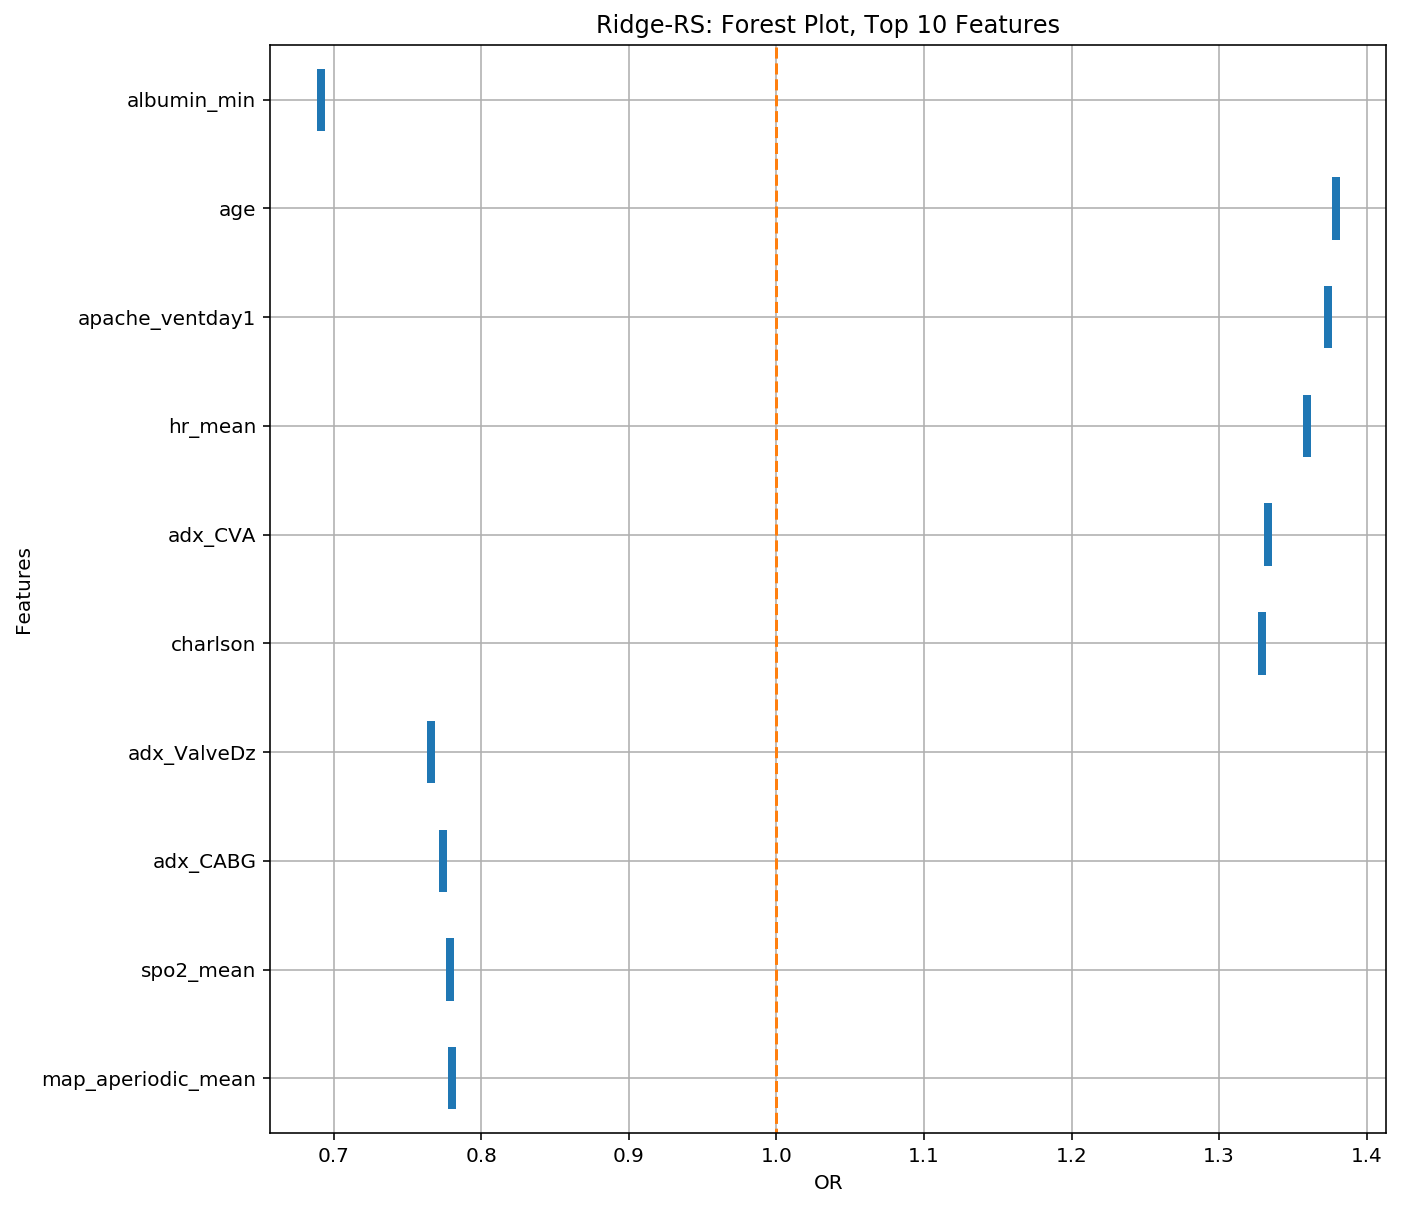

In [15]:
plt.figure(figsize=(10, 10))
bp = np.exp(ridge_rs_coef).T.plot.box(vert=False, return_type='dict', color = {'medians' : tableau20[0]}, 
                              medianprops = {'linewidth': 4, 'linestyle': 'solid'}, ax=plt.axes())
plt.title('Ridge-RS: Forest Plot, Top 10 Features')
plt.plot([1, 1], [0, 250], '--', color=tableau20[2])
plt.xlabel('OR')
plt.ylabel('Features')
plt.grid()
plt.savefig('./figures/ridge_RS-feat_OR.svg', bbox_inches='tight')
plt.show()

We then carry out the same steps in the HR cohort model.

,log_odds
spo2_mean,-0.425541
map_aperiodic_mean,-0.343830
gcs_motor,-0.330042
albumin_min,-0.294164
apache_ventday1,0.272396
adx_CVA,0.243985
rr_mean,0.239190
age,0.238600
charlson,0.202851
hr_mean,0.200511


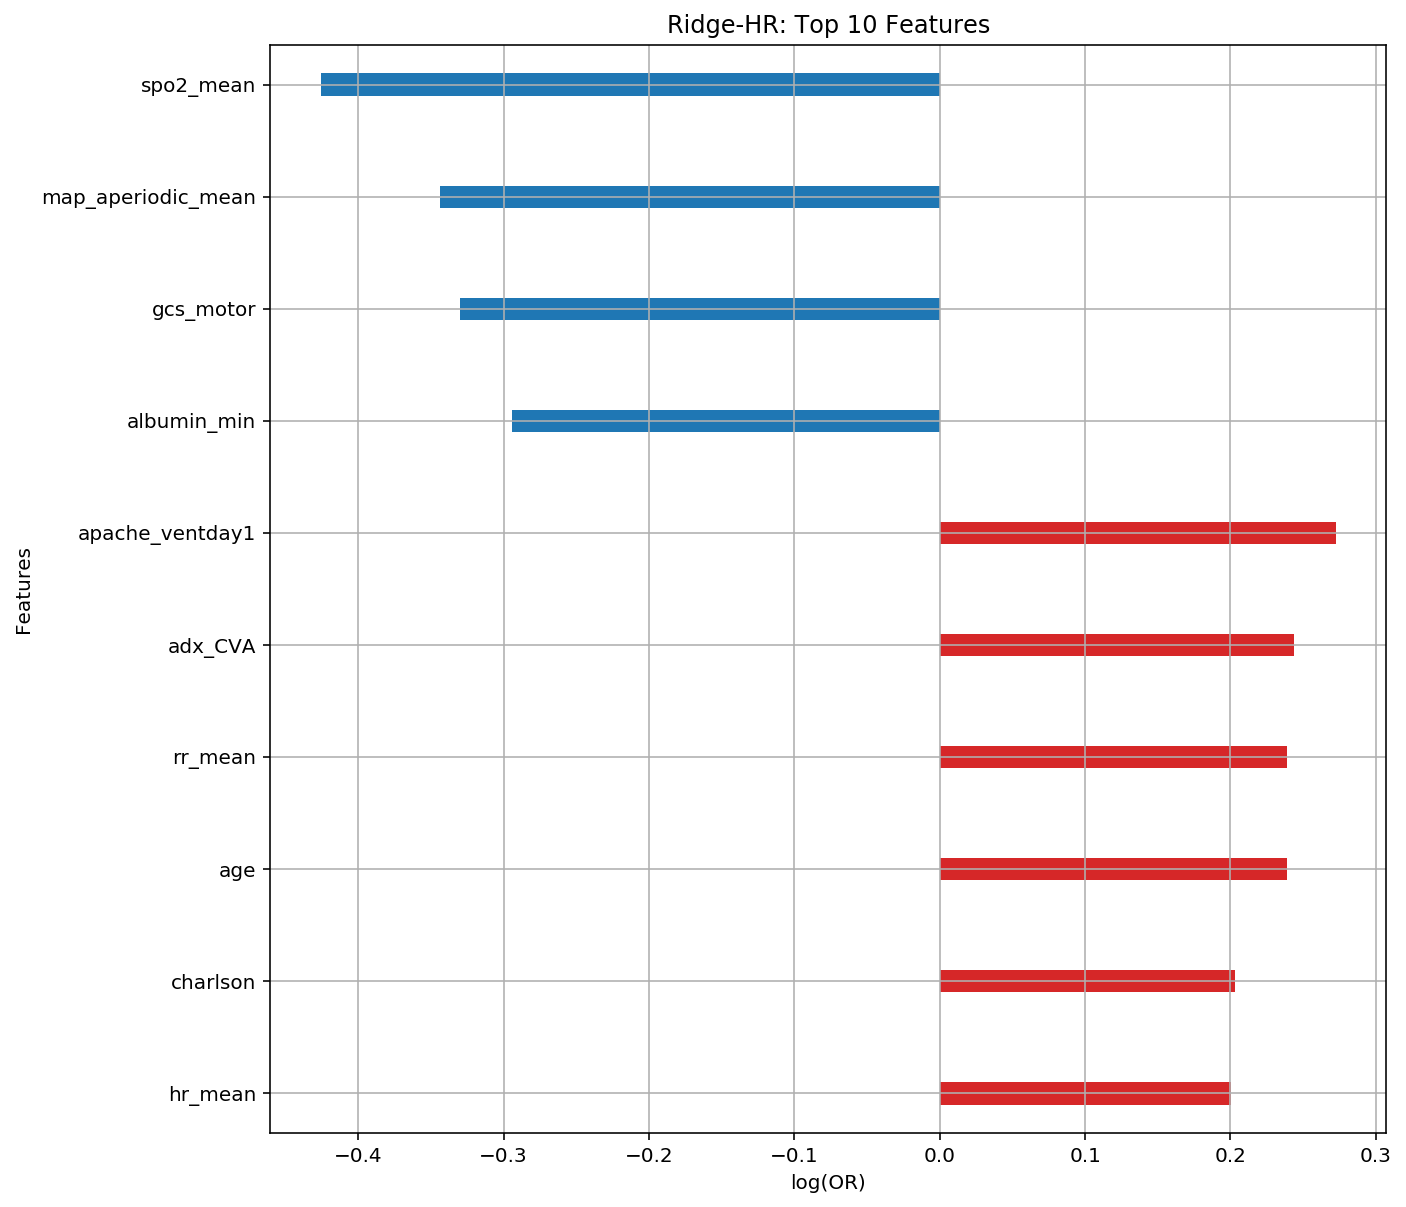

In [16]:
ridge_coef_HR = {k:v for k, v in zip(feature_names, ridge_classifier_HR.named_steps['ridge'].coef_.ravel())}
ridge_coef_HR = pd.DataFrame.from_dict(ridge_coef_HR, orient='index', columns=['log_odds'])
ridge_HR_coef = ridge_coef_HR.reindex(ridge_coef_HR.log_odds.abs().sort_values(ascending=False).index).iloc[0:10, :]
display(ridge_HR_coef)

# plotting
ridge_HR_coef = ridge_HR_coef.reindex(index=ridge_HR_coef.index[::-1])
pos_neg = ridge_HR_coef.log_odds > 0
color_map = pos_neg.map({True: tableau20[6], False: tableau20[0]})
plt.figure(figsize=(10, 10))
ridge_HR_coef.plot(kind='barh', grid=True, sort_columns=False,
                   title='Ridge-HR: Top 10 Features',
                   color=[color_map.values], ax=plt.axes(), width=0.20,
                   legend=False)
plt.xlabel('log(OR)')
plt.ylabel('Features')
plt.savefig('./figures/ridge_HR-feat.svg', bbox_inches='tight')
plt.show()

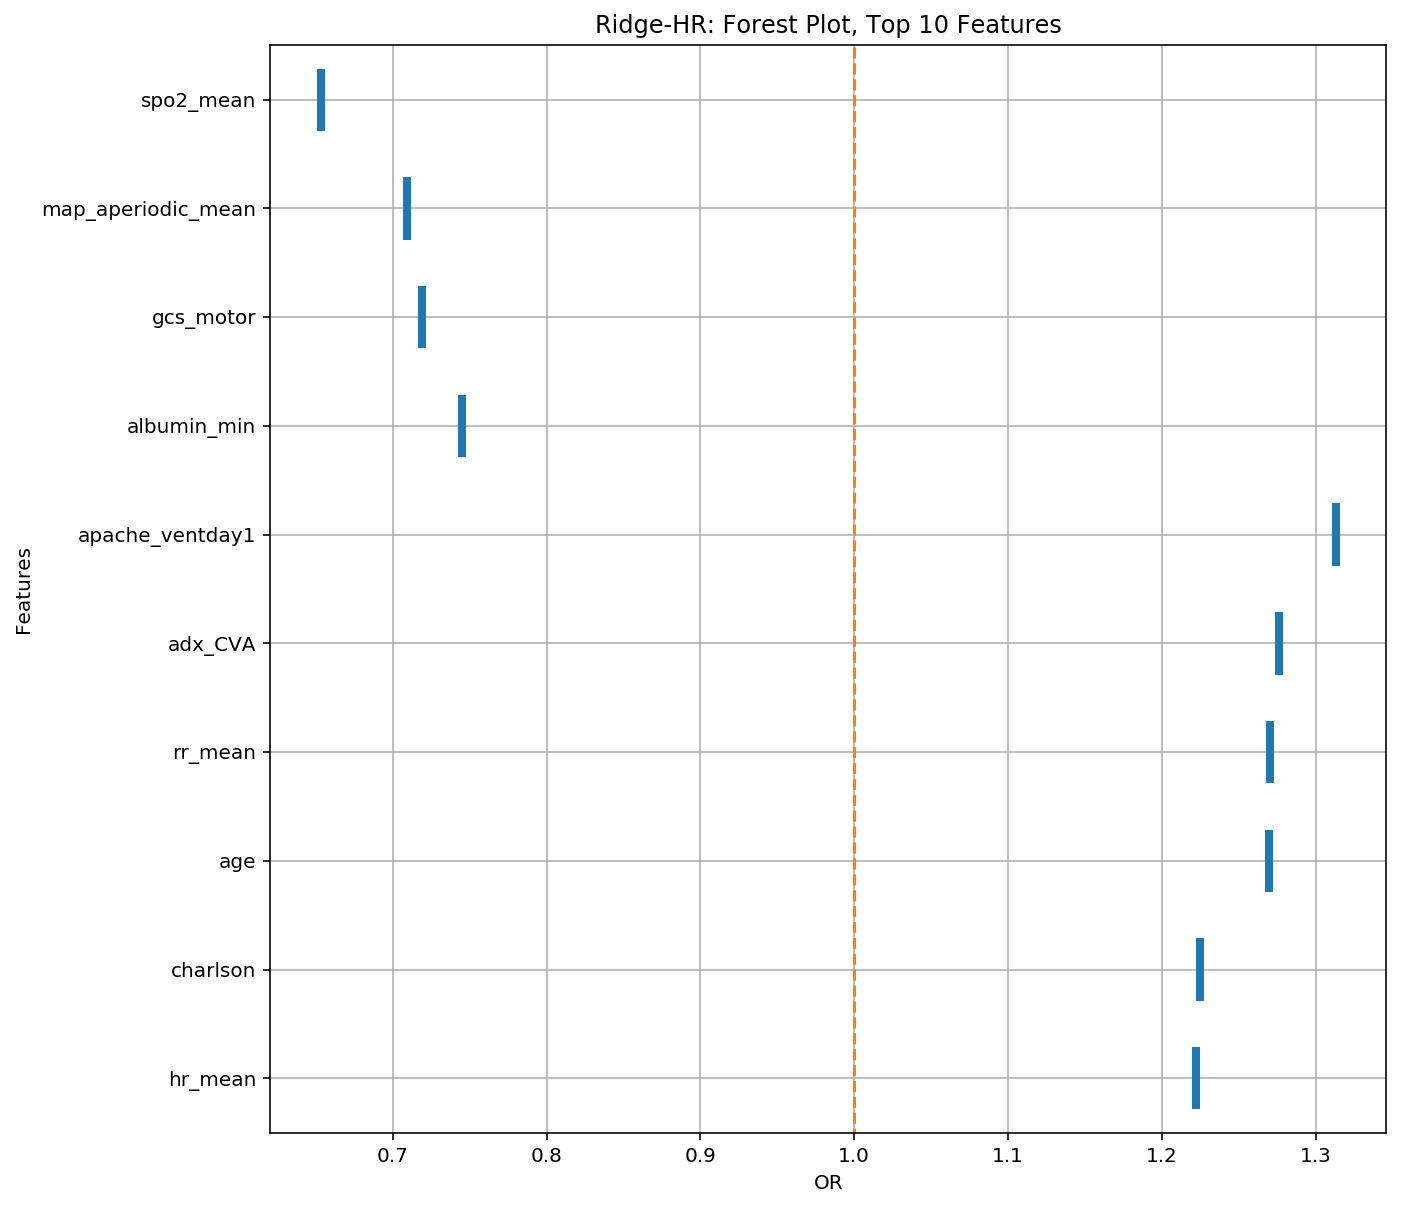

In [17]:
plt.figure(figsize=(10, 10))
bp = np.exp(ridge_HR_coef).T.plot.box(vert=False, return_type='dict', color = {'medians' : tableau20[0]}, 
                              medianprops = {'linewidth': 4, 'linestyle': 'solid'}, ax=plt.axes())
plt.title('Ridge-HR: Forest Plot, Top 10 Features')
plt.plot([1, 1], [0, 250], '--', color=tableau20[2])
plt.grid()
plt.xlabel('OR')
plt.ylabel('Features')
plt.savefig('./figures/ridge_HR-feat_OR.svg', bbox_inches='tight')
plt.show()

The top 10 features in both by $|log(OR)|$ are similar for both the RS and HR cohort models with notable small differences.

We next turn to the XGB models. For these we'll need to map the feature names onto the models internal representation of the features and then extract the importance matrices. Again we start with the RS cohort models. XGB also provides a built in function for visualizing the matrix.

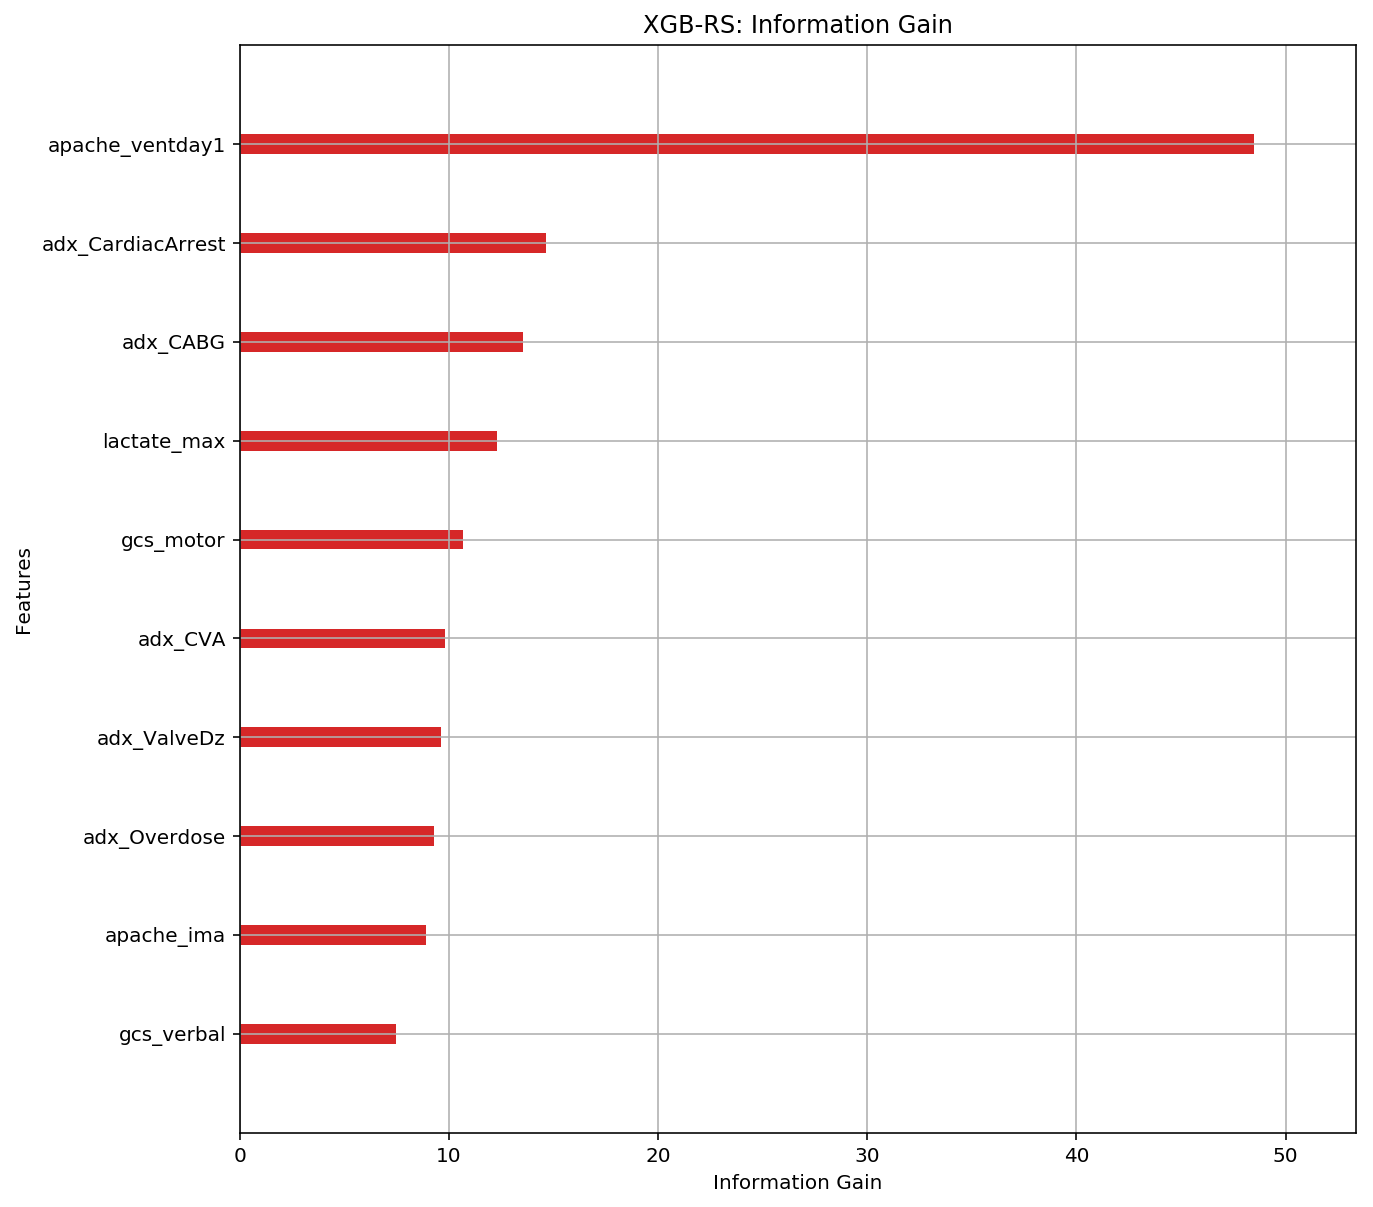

In [18]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=10, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
               title='XGB-RS: Information Gain')
plt.savefig('./figures/XGB_RS-feat.svg', bbox_inches='tight')
plt.show()

Using the same mapper, we can generate the same result for the HR cohort XGB model.

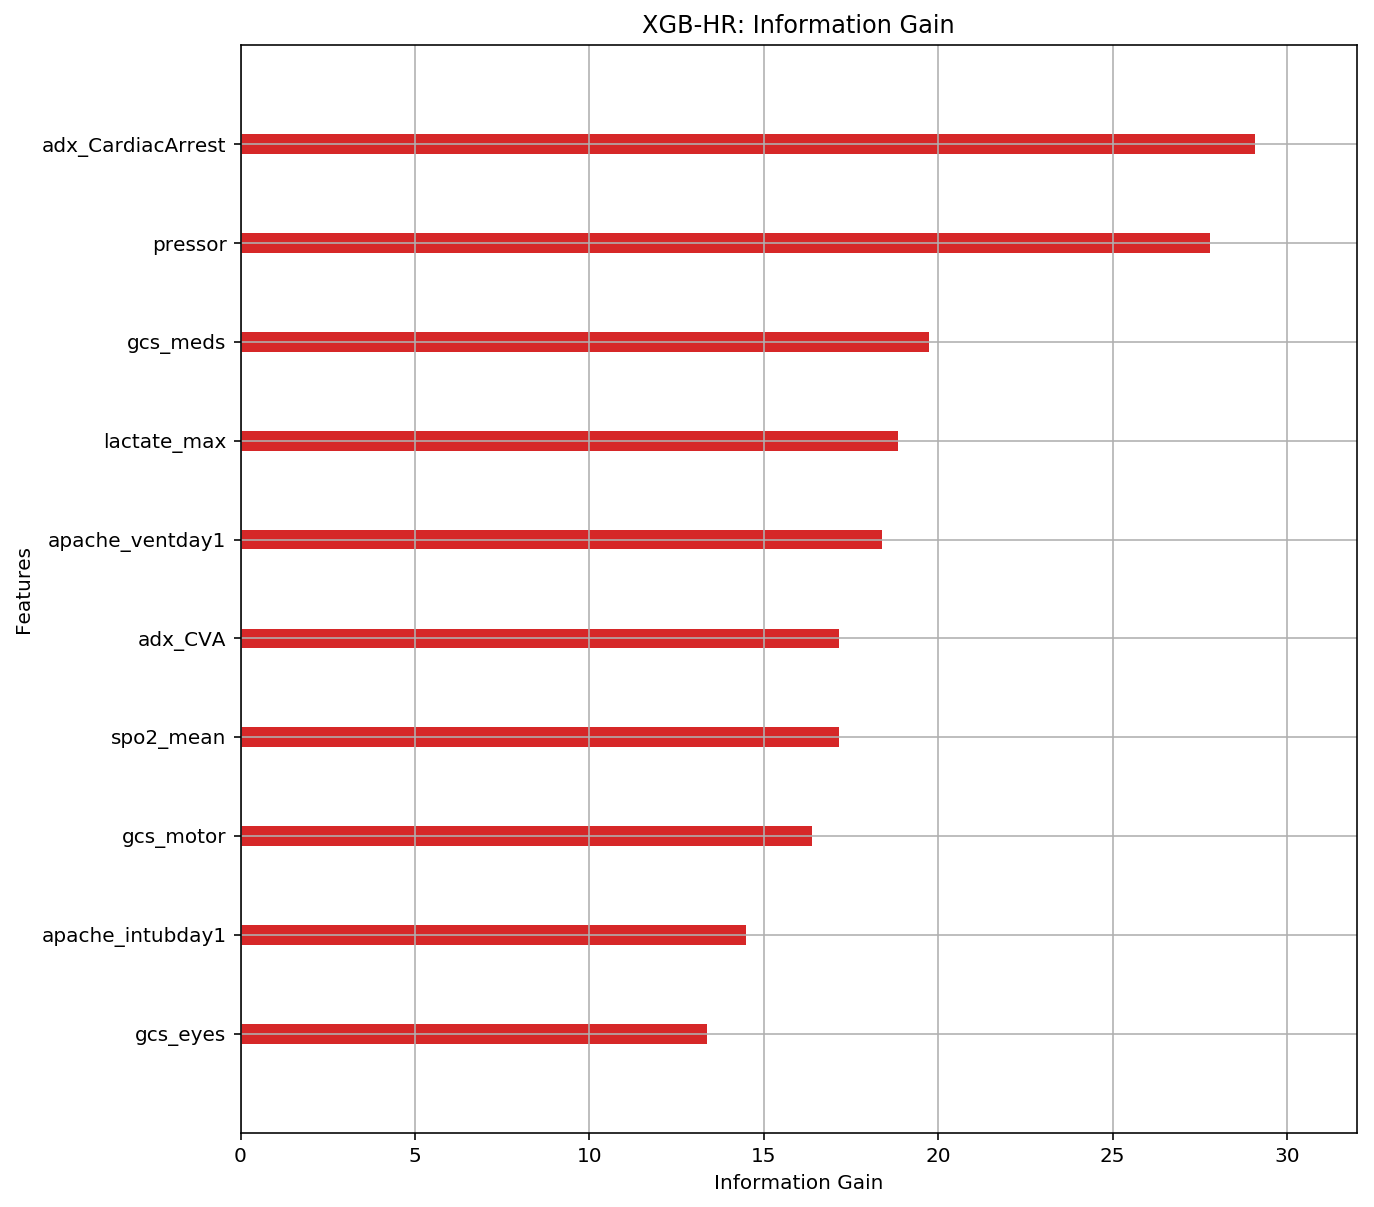

In [19]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier_HR.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=10, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
                title='XGB-HR: Information Gain')
plt.savefig('./figures/XGB_HR-feat.svg', bbox_inches='tight')
plt.show()

Again we note large overlaps in what features were _important_. For example, the information gain from lactate level in the HR cohort is greater than that in the full cohort. In both cases, admission for a cardiac arrest is very useful in predicting mortality, but more information is gained from the high-risk cohort.